In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
import matplotlib.patches as mpatches
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
!wget --quiet -O escapecalculator.py https://raw.githubusercontent.com/jbloomlab/SARS2-RBD-escape-calc/main/escapecalculator.py

In [3]:
import os
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from pyfish import fish_plot, process_data
# local import
from utils import read_mi, enrichment
from utils import AFFINITY, ESCAPE, MOI

In [4]:
INTERESTING = set(MOI).union(AFFINITY).union(ESCAPE)

In [5]:
def plot_mi(s, date):
    c = s[s['name'] == date].pivot_table(index='feature_codon_source',
                                         columns='feature_codon_target',
                                         values='outlier',
                                         aggfunc=max)
    
    c = c.reindex(index=sorted(INTERESTING),
                  columns=sorted(INTERESTING))
    
    cmap = plt.get_cmap('crest_r').copy()
    cmap.set_bad('xkcd:light grey')
    
    colors = []
    for x in c.index:
        if x in AFFINITY:
            colors.append('#ef3b2cff')
        elif x in ESCAPE:
            colors.append('#2171b5ff')
        elif x in MOI:
            colors.append('#fec44fff')
        else:
            colors.append('xkcd:grey')
    
    c.index = c.index.astype(int)
    c.columns = c.columns.astype(int)
    
    cm = sns.clustermap(c, cmap=cmap,
                        row_cluster=False, col_cluster=False,
                        row_colors=colors,
                        col_colors=colors,
                        linewidths=0.005,
                        cbar_pos=None,
                        figsize=(7, 7),
                        vmin=1, vmax=4)
    
    cm.ax_heatmap.set_xlabel('spike codon')
    cm.ax_heatmap.set_ylabel('spike codon')
    
    cm.ax_heatmap.set_xticks([x + 0.5 for x in range(c.shape[1])],
                             c.columns,
                             fontsize=13)
    cm.ax_heatmap.set_yticks([x + 0.5 for x in range(c.shape[0])],
                             c.index,
                             fontsize=13)
    
    cm.ax_heatmap.set_title(date, y=1.04)
    
    plt.savefig(f'time_{date}.png',
                dpi=300,
                bbox_inches='tight',
                transparent=True)
    plt.savefig(f'time_{date}.svg',
                dpi=300,
                bbox_inches='tight',
                transparent=True);

In [6]:
a = read_mi(f'../out/all-notime/mi_annotated.tsv.gz',
            'all', date=False)

In [7]:
no_time = read_mi(f'../out/time-subsets-notime/2023-03/mi_annotated.tsv.gz',
                  '2023-03',
                  date=True)

In [8]:
df = []
for name in os.listdir('../out/time-subsets/'):
    df.append(read_mi(f'../out/time-subsets/{name}/mi_annotated.tsv.gz',
                      name,
                      date=True))
df = pd.concat(df)

In [9]:
df.groupby(['year', 'month'])['pos_source'].count()

year  month
2020  2        43742
      3        75058
      4        80124
      5        68900
      6        71436
      7        57892
      8        50630
      9        42468
      10       37926
      11       21948
      12       19732
2021  1        19618
      2        10242
      3         9090
      4         8558
      5         9216
      6         8054
      7         6026
      8         5276
      9         4788
      10        8386
      11        6818
      12        3634
2022  1         3016
      2         1666
      3         1176
      4          648
      5          508
      6          520
      7          490
      8          570
      9          594
      10         566
      11         680
      12         554
2023  1          578
      2          608
      3          742
Name: pos_source, dtype: int64

In [10]:
count = df.groupby(['name', 'outlier'])['pos_source'].count().reset_index()

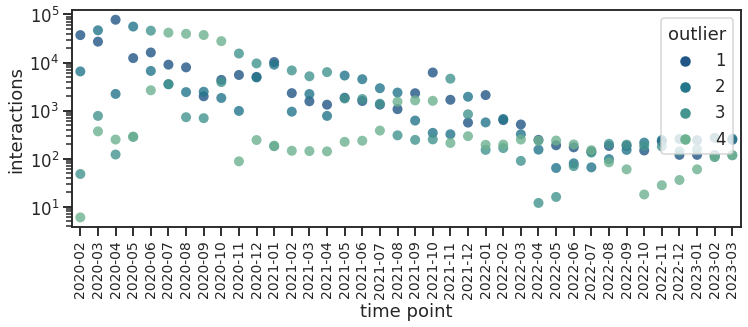

In [11]:
plt.figure(figsize=(12, 4))

sns.stripplot(data=count,
              y='pos_source',
              x='name',
              hue='outlier',
              size=10,
              jitter=0,
              alpha=0.8,
              palette=sns.color_palette('crest_r', 4))

plt.xticks(rotation=90,
           size=14)

plt.legend(facecolor='w',
           title='outlier')

plt.ylabel('interactions')
plt.xlabel('time point')

plt.yscale('log')

plt.savefig('time_1.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_1.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

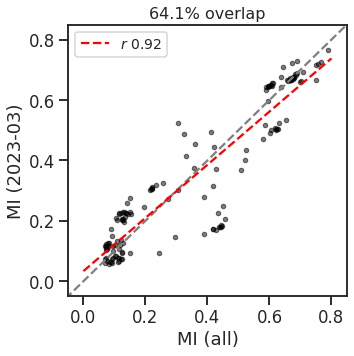

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

a = a.set_index(['pos_source', 'pos_target'])
no_time = no_time.set_index(['pos_source', 'pos_target'])

idx = a.index.intersection(no_time.index)

av = a.loc[idx]['mi']
sv = no_time.loc[idx]['mi']

ax.plot(av,
        sv,
        'k.',
        alpha=0.3,
        rasterized=True)
ax.plot([-1, 1], [-1, 1],
        '--',
        color='grey')

lr = stats.linregress(av, sv)

ax.plot([0, 0.8],
        [lr.intercept,
         lr.slope * 0.8 + lr.intercept],
        'r--',
        label=f'$r$ {lr.rvalue:.2f}')

ax.legend(facecolor='w', fontsize=14)

ax.set_xlim(-0.05, 0.85)
ax.set_ylim(-0.05, 0.85)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

ax.set_ylabel('MI (2023-03)')
ax.set_xlabel('MI (all)')

ax.set_title(f'{av.shape[0] * 100 / a.shape[0]:.1f}% overlap',
             fontsize=16)

a = a.reset_index()
no_time = no_time.reset_index()

plt.savefig('time_2.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_2.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [13]:
p = pd.read_csv('../out/spikes/2023-03/2023-03.EC', sep=' ', header=None)
p.columns = ['pos_source', 'base_source',
             'pos_target', 'base_target',
             '_', 'plmc']

In [14]:
m = no_time[(no_time['gene_source'] == 'S') &
            (no_time['gene_target'] == 'S')].sort_values('pos_source').copy()
m['pos_source'] = m['pos_source'] - 21562
m['pos_target'] = m['pos_target'] - 21562

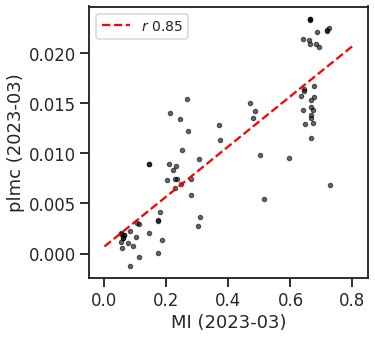

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))

m = m.set_index(['pos_source', 'pos_target'])
p = p.set_index(['pos_source', 'pos_target'])

idx = m.index.intersection(p.index)

av = m.loc[idx]['mi']
sv = p.loc[idx]['plmc']

ax.plot(av,
        sv,
        'k.',
        alpha=0.6,
        rasterized=True)


lr = stats.linregress(av, sv)

ax.plot([0, 0.8],
        [lr.intercept,
         lr.slope * 0.8 + lr.intercept],
        'r--',
        label=f'$r$ {lr.rvalue:.2f}')

ax.legend(facecolor='w', fontsize=14)
ax.set_xlim(-0.05, 0.85)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])

ax.set_ylabel('plmc (2023-03)')
ax.set_xlabel('MI (2023-03)')

a = m.reset_index()
p = p.reset_index()

plt.savefig('time_3.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_3.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [16]:
res = []
for name in sorted(df['name'].unique()):
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])
    
    s = df[df['name'] == name]
    
    o = enrichment(s)
    
    print(name)

    res.append(['actual', year, month, name,
                o[(o['type'] == 'original') &
                  (o['randomization'] == 'any_positions')]['odds-ratio'].values[0],
                o[(o['type'] == 'original') &
                  (o['randomization'] == 'any_positions')]['p-value'].values[0]])

    for odds_ratio, pvalue in o[(o['type'] == 'random') &
                                (o['randomization'] == 'any_positions')
                                        ][['odds-ratio', 'p-value']].values:
        res.append(['random', year, month, name, odds_ratio, pvalue])

r = pd.DataFrame(res,
                 columns=['set',
                          'year', 'month',
                          'name', 'odds-ratio',
                          'p-value'])

2020-02
2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


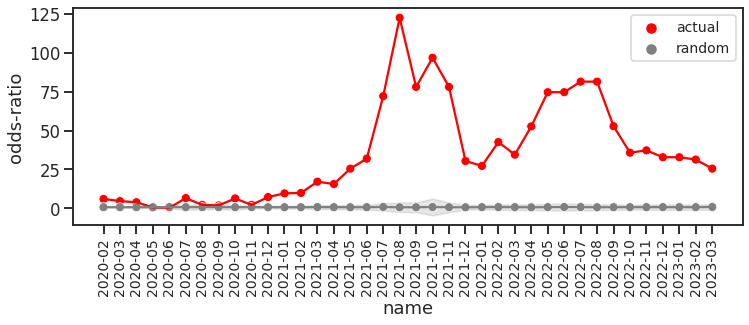

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=r,
             x='name',
             y='odds-ratio',
             hue='set',
             errorbar='sd',
             ax=ax,
             legend=False,
             palette=['r', 'grey'])
sns.scatterplot(data=r.groupby(['name', 'set'])[['odds-ratio']].mean().reset_index(),
                x='name',
                y='odds-ratio',
                hue='set',
                ax=ax,
                palette=['r', 'grey'])

plt.legend(facecolor='w', fontsize=14)

plt.xticks(rotation=90,
           fontsize=14)

plt.savefig('time_4.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_4.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

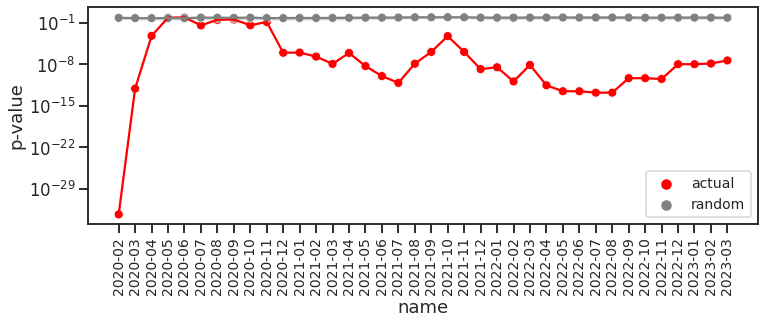

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=r,
             x='name',
             y='p-value',
             hue='set',
             errorbar='sd',
             ax=ax,
             legend=False,
             palette=['r', 'grey'])
sns.scatterplot(data=r.groupby(['name', 'set'])[['p-value']].mean().reset_index(),
                x='name',
                y='p-value',
                hue='set',
                ax=ax,
                palette=['r', 'grey'])

plt.xticks(rotation=90,
           fontsize=14)
plt.yscale('log')

plt.legend(facecolor='w', fontsize=14)

plt.savefig('time_5.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_5.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [19]:
r1 = r[~r['name'].isin(['2020-02', '2020-03'])]

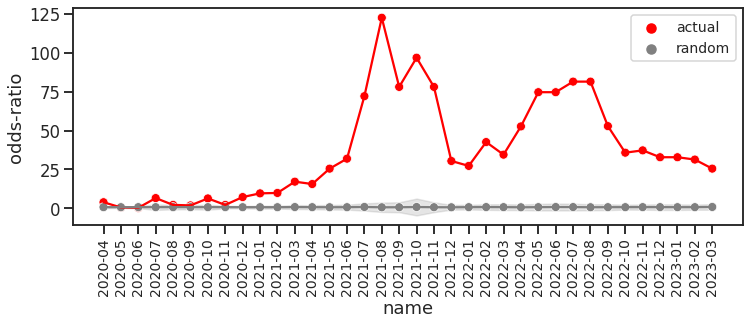

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=r1,
             x='name',
             y='odds-ratio',
             hue='set',
             errorbar='sd',
             ax=ax,
             legend=False,
             palette=['r', 'grey'])
sns.scatterplot(data=r1.groupby(['name', 'set'])[['odds-ratio']].mean().reset_index(),
                x='name',
                y='odds-ratio',
                hue='set',
                ax=ax,
                palette=['r', 'grey'])

plt.legend(facecolor='w', fontsize=14)

plt.xticks(rotation=90,
           fontsize=14)

plt.savefig('time_4a.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_4a.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

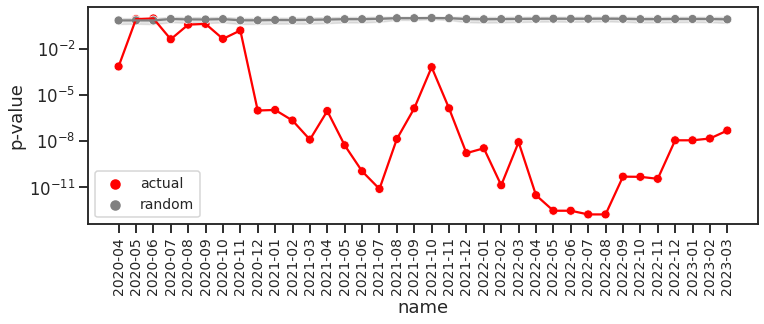

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=r1,
             x='name',
             y='p-value',
             hue='set',
             errorbar='sd',
             ax=ax,
             legend=False,
             palette=['r', 'grey'])
sns.scatterplot(data=r1.groupby(['name', 'set'])[['p-value']].mean().reset_index(),
                x='name',
                y='p-value',
                hue='set',
                ax=ax,
                palette=['r', 'grey'])

plt.xticks(rotation=90,
           fontsize=14)
plt.yscale('log')

plt.legend(facecolor='w', fontsize=14)

plt.savefig('time_5a.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_5a.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [22]:
dist = df.groupby(['name', 'outlier'])['distance'].mean().reset_index()

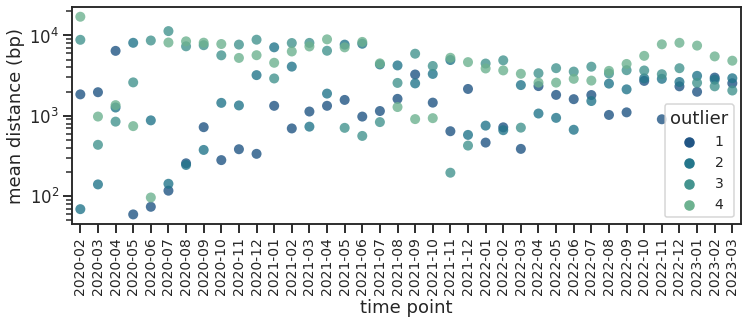

In [23]:
plt.figure(figsize=(12, 4))

sns.stripplot(data=dist,
              y='distance',
              x='name',
              hue='outlier',
              size=10,
              jitter=0,
              alpha=0.8,
              palette=sns.color_palette('crest_r', 4))

plt.xticks(rotation=90,
           size=14)

plt.legend(facecolor='w',
           title='outlier',
           fontsize=14)

plt.ylabel('mean distance (bp)')
plt.xlabel('time point')

plt.yscale('log')

plt.savefig('time_6.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_6.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [24]:
dist = df.groupby(['name', 'outlier'])['distance'].median().reset_index()

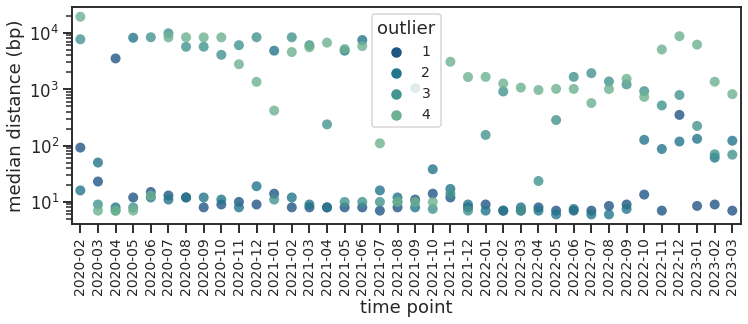

In [25]:
plt.figure(figsize=(12, 4))

sns.stripplot(data=dist,
              y='distance',
              x='name',
              hue='outlier',
              size=10,
              jitter=0,
              alpha=0.8,
              palette=sns.color_palette('crest_r', 4))

plt.xticks(rotation=90,
           size=14)

plt.legend(facecolor='w',
           title='outlier',
           fontsize=14)

plt.ylabel('median distance (bp)')
plt.xlabel('time point')

plt.yscale('log')

plt.savefig('time_7.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_7.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [26]:
s1 = df[(~df['name'].isin(['2020-02',
                           '2020-03'])) &
        (df['gene_source'] == 'S') &
        (df['gene_target'] == 'S') &
        ((df['feature_codon_source'] == 501) &
         (df['feature_codon_target'] == 498))].copy()

s1 = s1.pivot_table(index=['feature_codon_source',
                          'feature_codon_target'],
                   columns='name',
                   values='outlier',
                   aggfunc=max).reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            '2020-03'])]['name'].unique()))

In [27]:
s2 = df[(~df['name'].isin(['2020-02',
                           '2020-03'])) &
        (df['gene_source'] == 'S') &
        (df['gene_target'] == 'S') &
        ((df['feature_codon_source'].isin(AFFINITY)) &
         (df['feature_codon_target'].isin(INTERESTING.difference(AFFINITY))))].copy()

s2 = s2.pivot_table(index=['feature_codon_source',
                          'feature_codon_target'],
                   columns='name',
                   values='outlier',
                   aggfunc=max).reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            '2020-03'])]['name'].unique()))

In [28]:
s3 = df[(~df['name'].isin(['2020-02',
                           '2020-03'])) &
        (df['gene_source'] == 'S') &
        (df['gene_target'] == 'S') &
        ((df['feature_codon_source'].isin(INTERESTING.difference(AFFINITY))) &
         (df['feature_codon_target'].isin(INTERESTING.difference(AFFINITY))))].copy()

s3 = s3.pivot_table(index=['feature_codon_source',
                          'feature_codon_target'],
                   columns='name',
                   values='outlier',
                   aggfunc=max).reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            '2020-03'])]['name'].unique()))

In [29]:
s = pd.concat([s1, s2])

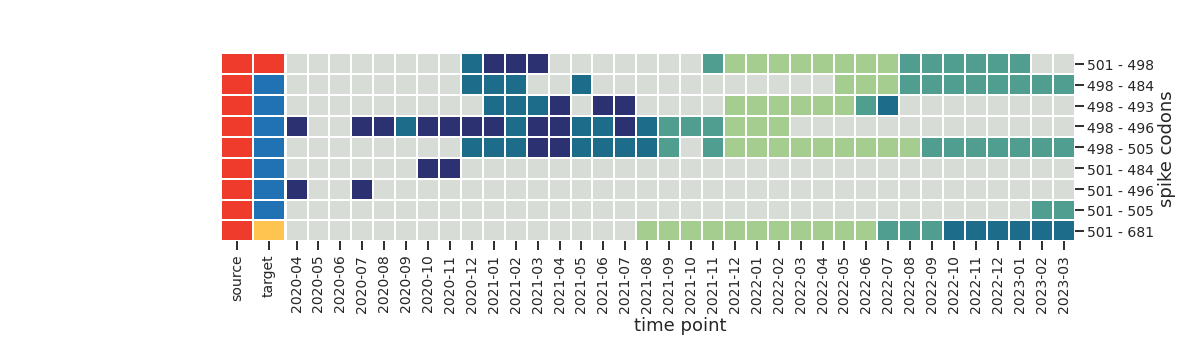

In [30]:
cmap = plt.get_cmap('crest_r').copy()
cmap.set_bad('xkcd:light grey')

colors1 = []
colors2 = []
for x, y in s.index:
    if x in AFFINITY:
        colors1.append('#ef3b2cff')
    elif x in ESCAPE:
        colors1.append('#2171b5ff')
    elif x in MOI:
        colors1.append('#fec44fff')
    else:
        colors1.append('xkcd:grey')

    if y in AFFINITY:
        colors2.append('#ef3b2cff')
    elif y in ESCAPE:
        colors2.append('#2171b5ff')
    elif y in MOI:
        colors2.append('#fec44fff')
    else:
        colors2.append('xkcd:grey')

cm = sns.clustermap(s, cmap=cmap,
                    row_cluster=False, col_cluster=False,
                    row_colors=pd.DataFrame([[a, b] for a, b in zip(colors1, colors2)],
                                            columns=['source', 'target'],
                                            index=s.index),
                    linewidths=0.005,
                    cbar_pos=None,
                    figsize=(17, 5),
                    vmin=1, vmax=4)

cm.ax_heatmap.set_xlabel('time point')
cm.ax_heatmap.set_ylabel('spike codons')

cm.ax_heatmap.set_xticks([x + 0.5 for x in range(s.shape[1])],
                         s.columns,
                         fontsize=14)
cm.ax_heatmap.set_yticks([x + 0.5 for x in range(s.shape[0])],
                         [f'{int(x)} - {int(y)}' for x, y in s.index],
                         fontsize=14)

cm.ax_row_colors.set_xticks([0.5, 1.5],
                            ['source', 'target'],
                            fontsize=14)

plt.savefig('time_8.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_8.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [31]:
s = df[(df['gene_source'] == 'S') &
       (df['gene_target'] == 'S') &
       ((df['feature_codon_source'].isin(INTERESTING)) |
        (df['feature_codon_target'].isin(INTERESTING)))].copy()

/home/marco/.local/lib/python3.8/site-packages/seaborn/matrix.py:715: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self._figure = plt.figure(figsize=figsize)


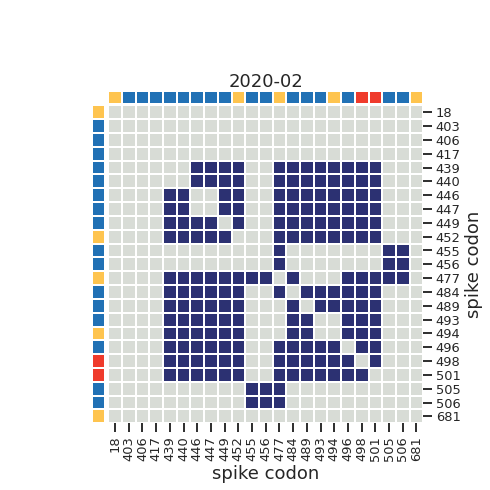

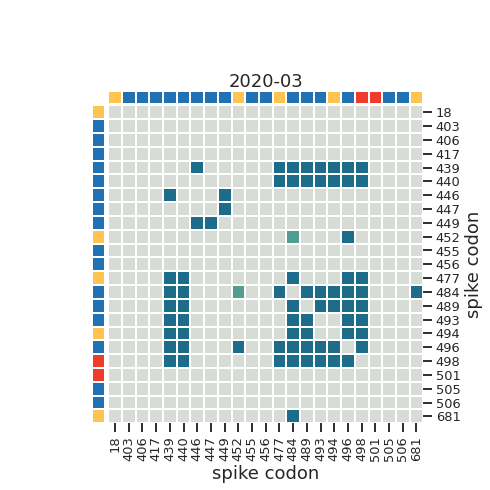

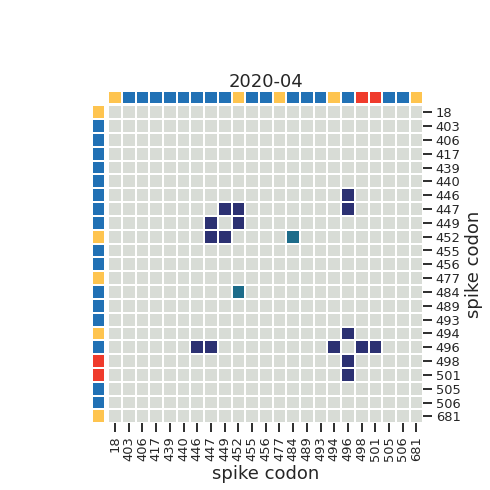

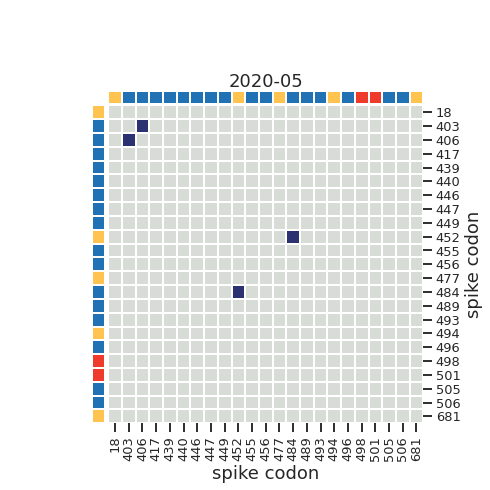

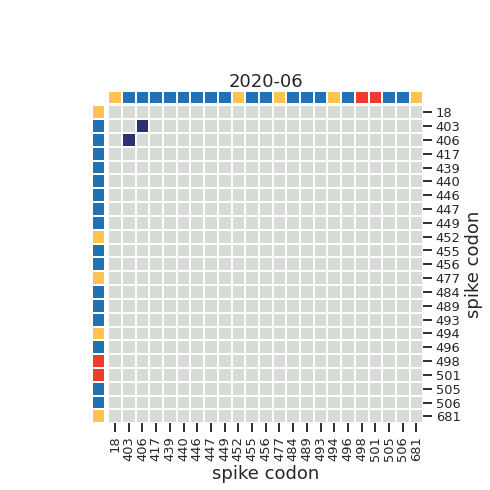

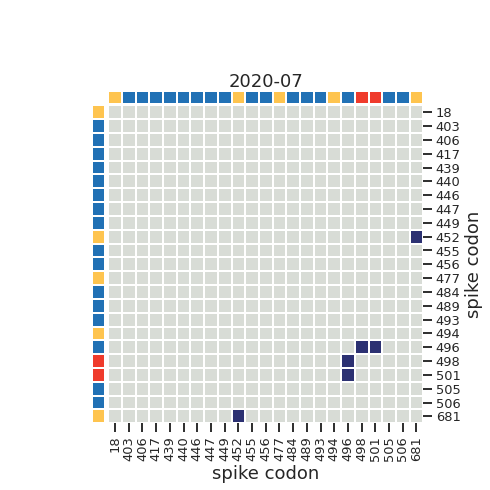

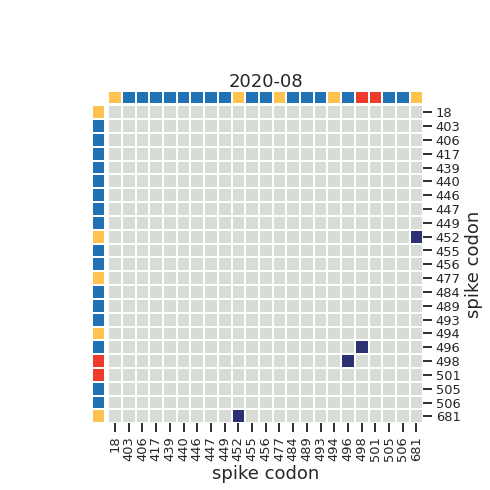

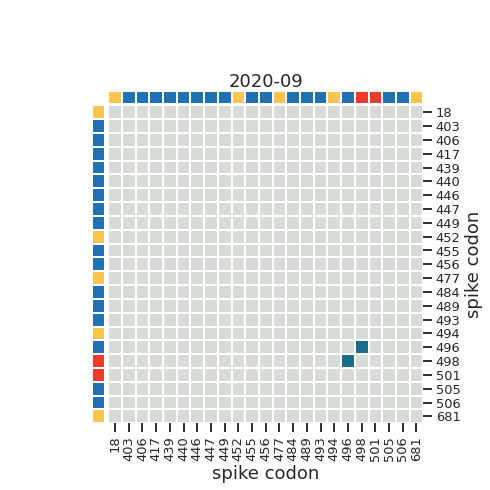

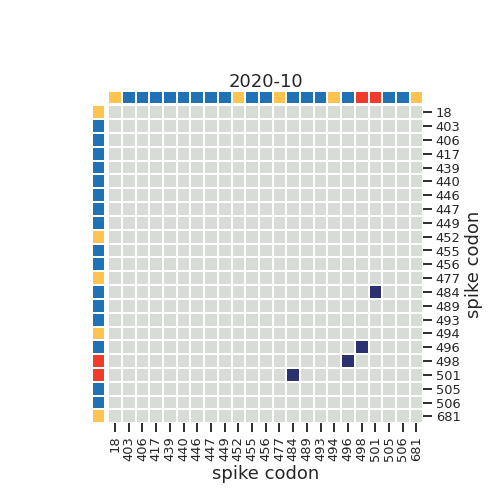

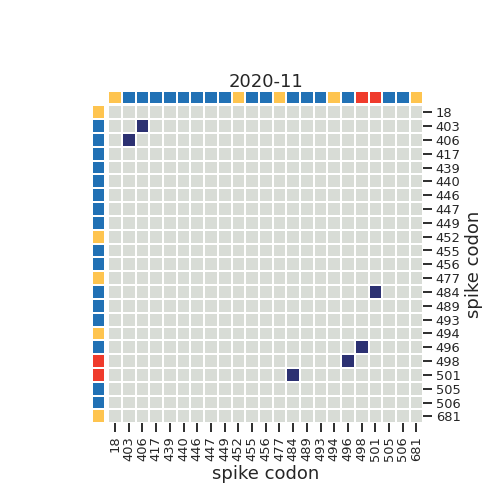

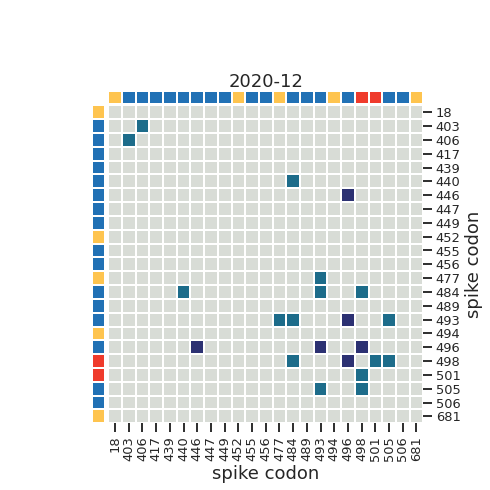

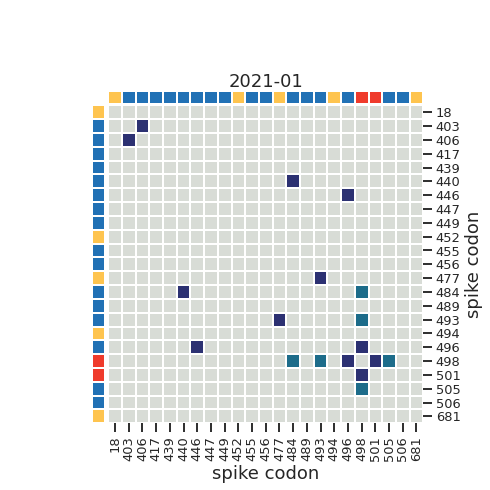

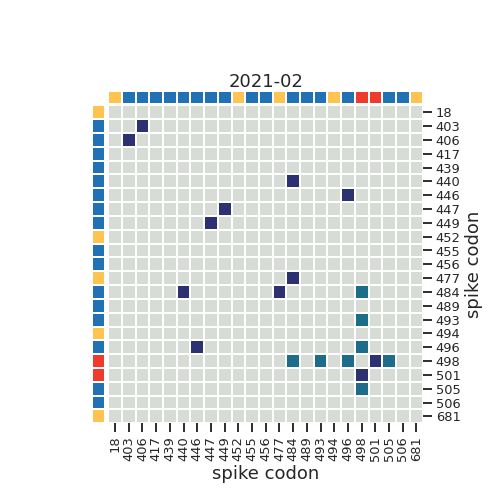

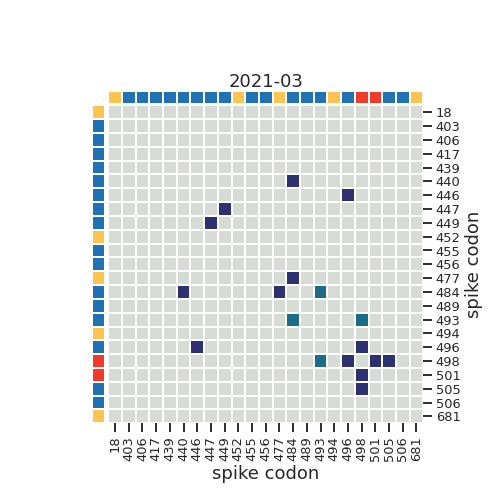

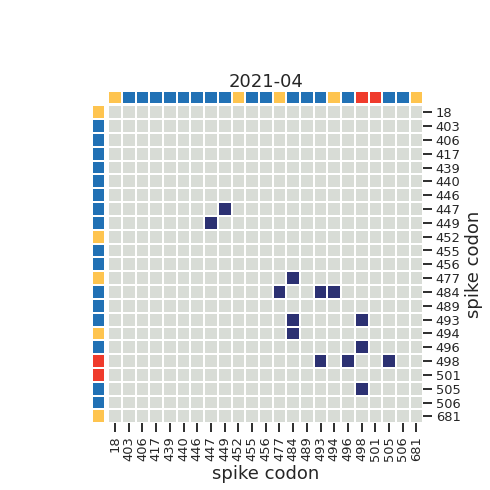

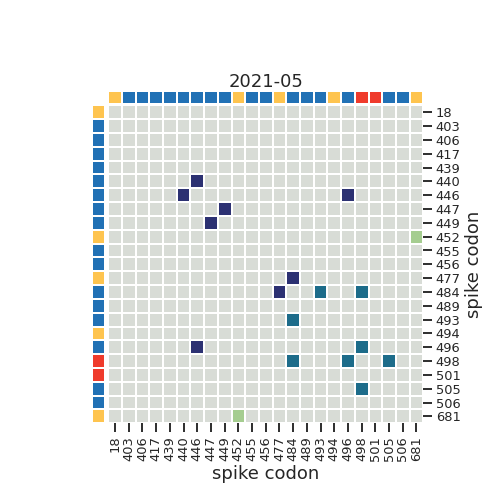

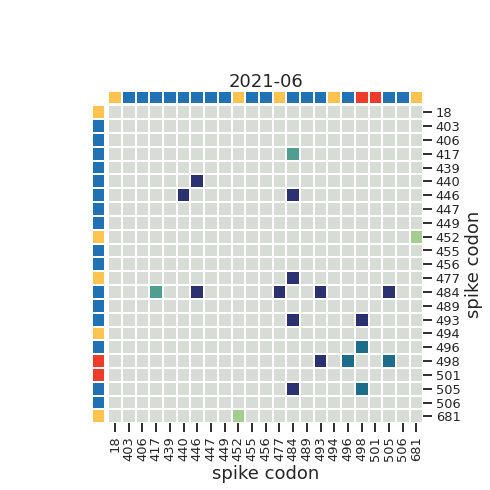

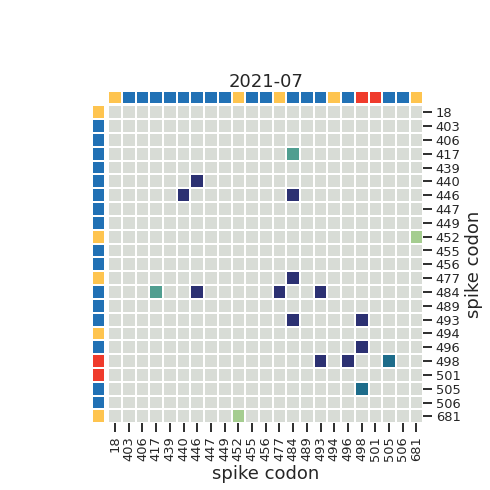

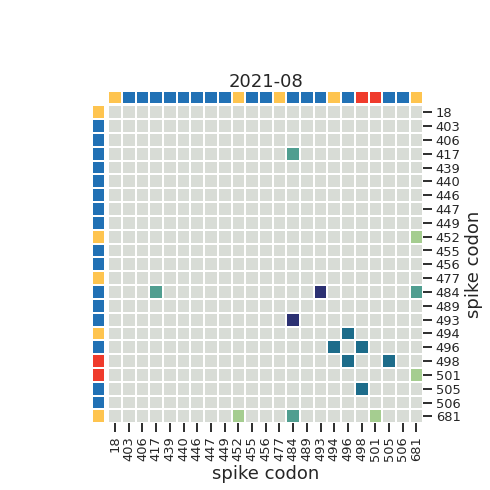

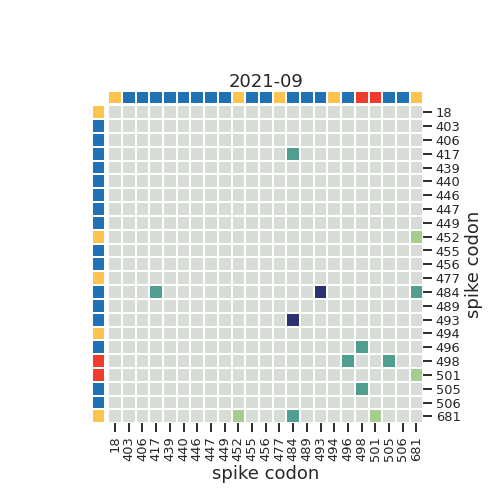

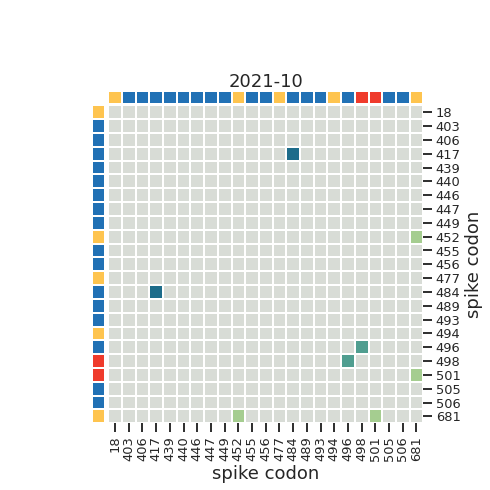

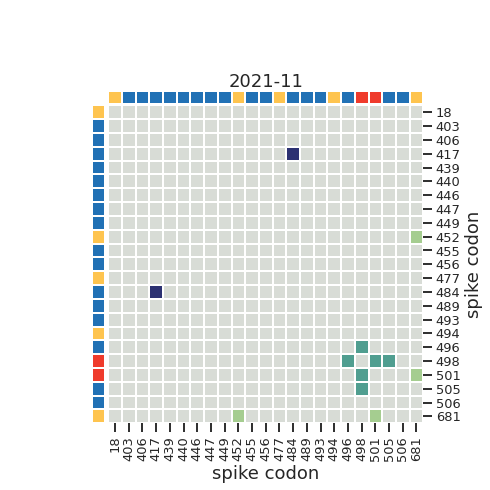

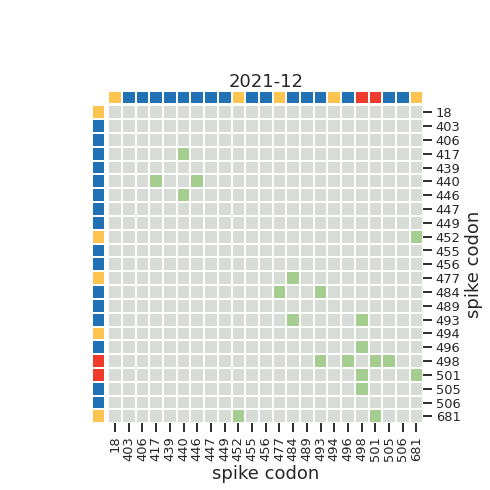

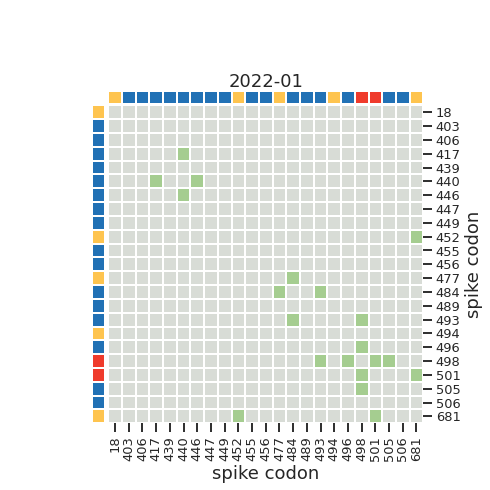

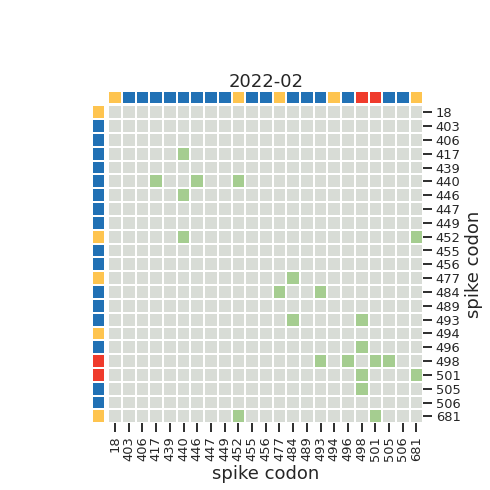

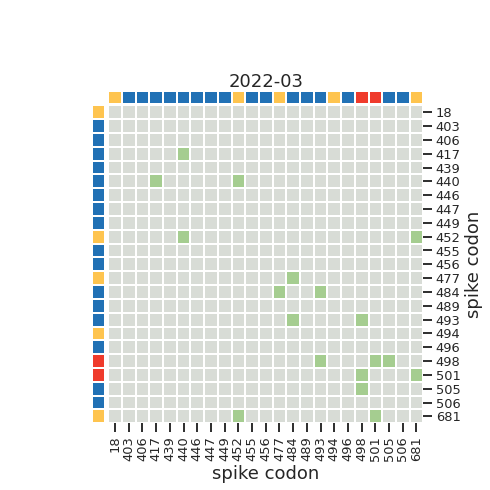

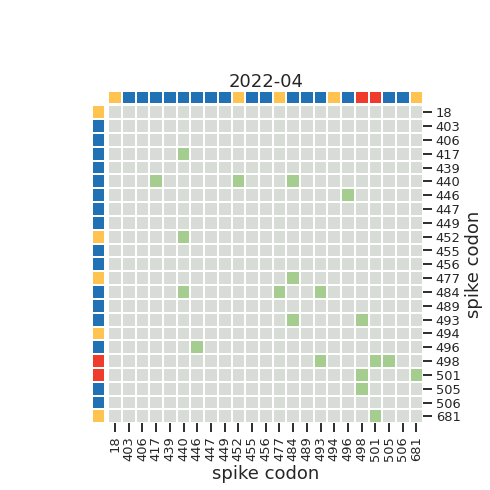

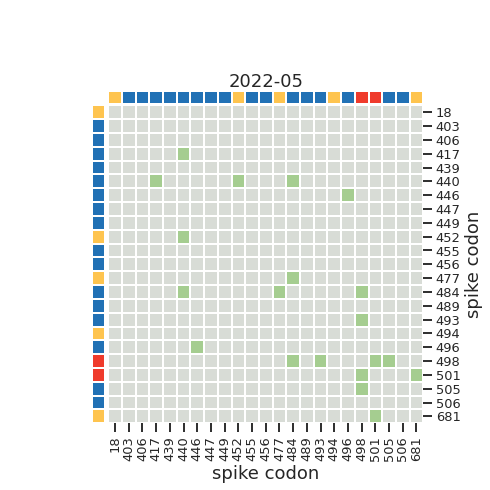

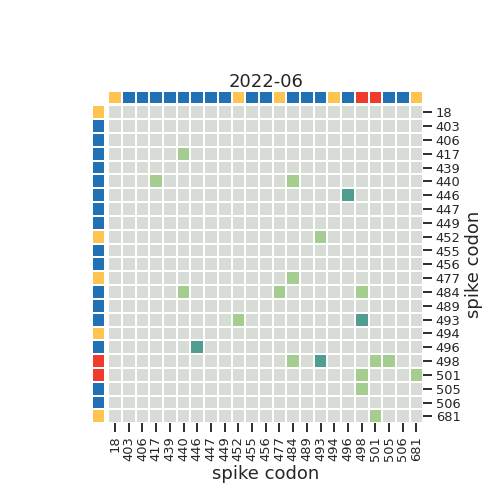

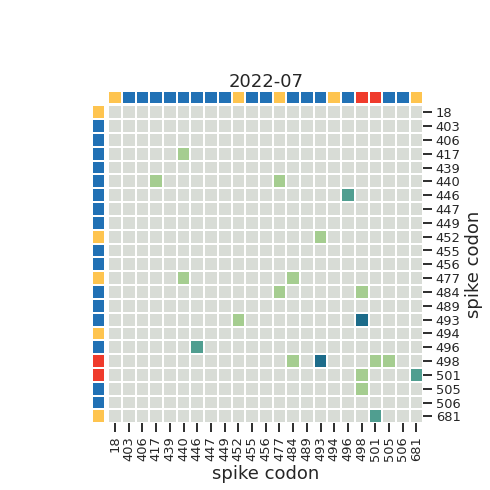

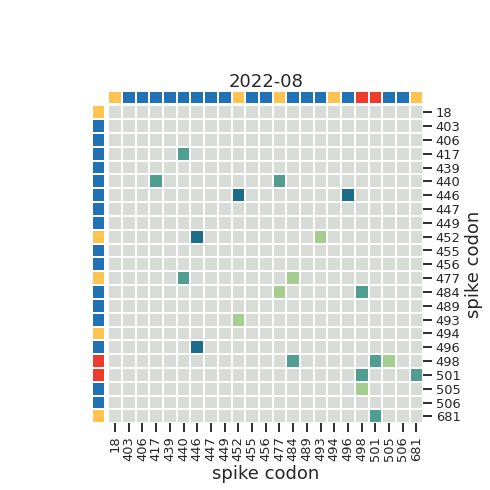

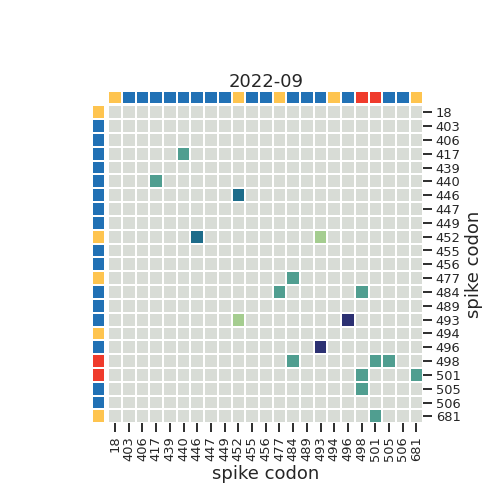

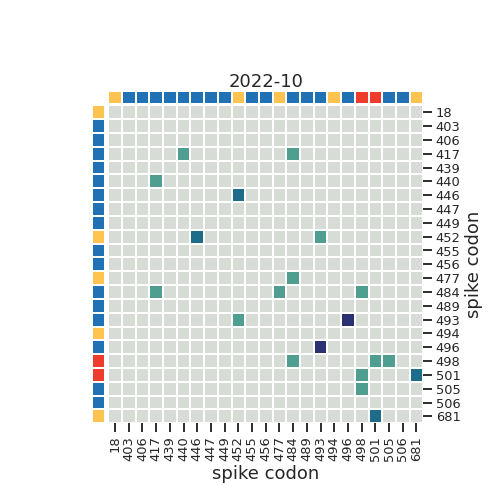

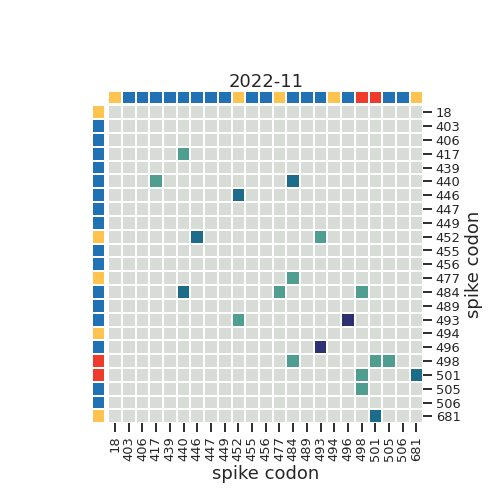

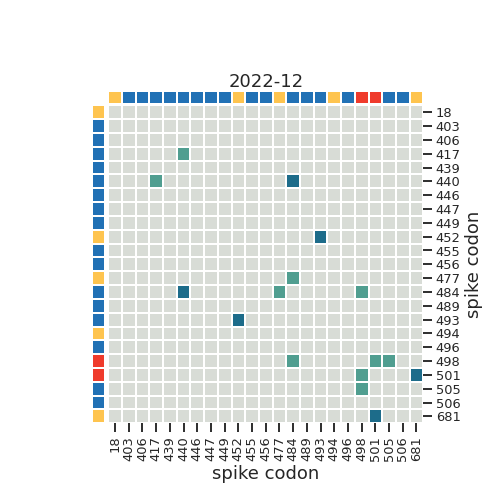

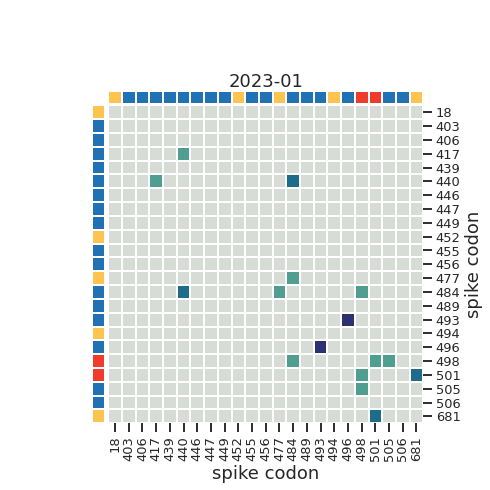

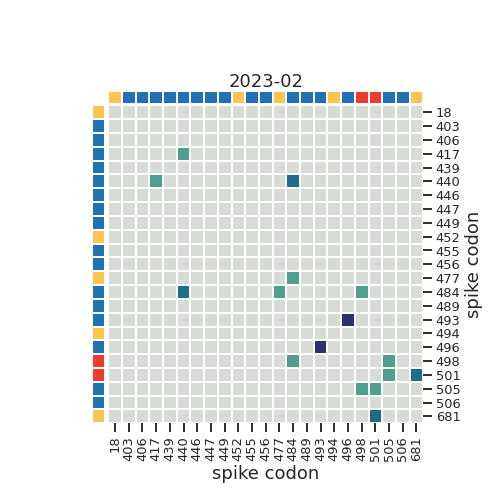

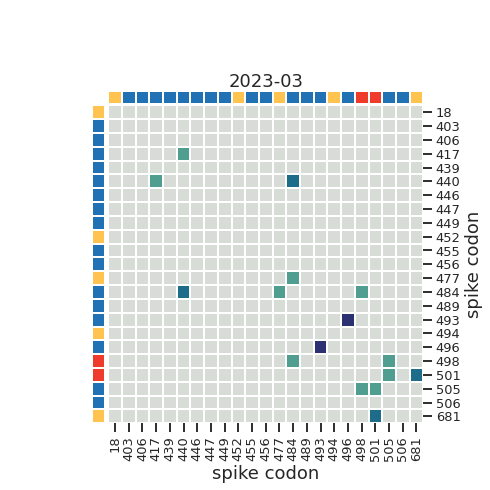

In [32]:
for date in sorted(s['name'].unique()):
    plot_mi(s, date)

In [33]:
!ffmpeg -framerate 2 -pattern_type glob -i 'time_20*.png' -filter_complex "[0:v] split [a][b];[a] palettegen [p];[b][p] paletteuse" spike.gif -y 2> /dev/null

In [34]:
res = []

d = {}
cw = {}
clades = {}

for f in os.listdir('../out/time-lineages/'):
    l = pd.read_csv(f'../out/time-lineages/{f}', sep='\t',
                    usecols=['seqName', 'clade', 'Nextclade_pango',
                             'partiallyAliased', 'clade_nextstrain',
                             'clade_who', 'clade_display'])
    date = f.split('.')[0]
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])

    tmp = l.set_index('clade_display')['clade_who'].dropna().to_dict()
    for k, v in tmp.items():
        d[k] = v
        cw[v] = cw.get(v, set())
        cw[v].add(k)
        clades[v] = clades.get(v, [])
        if k not in clades[v]:
            clades[v].append(k)
    
    l = l.groupby('clade_display')['seqName'].count().reset_index()
    l = l.rename(columns={'seqName': 'count'})
    l['name'] = date
    l['year'] = year
    l['month'] = month

    res.append(l)
r = pd.concat(res)

In [35]:
rr = r.pivot_table(index='clade_display',
                   columns='name',
                   values='count')
rr = rr.fillna(0)
rr = rr / rr.sum()
rr.T.to_csv('clades.tsv', sep='\t')

In [36]:
r['clade_display'].unique()

array(['19B', '20A', '20B', '20C', '20D', '20E', '20G', '20H (Beta)',
       '20I (Alpha)', '20J (Gamma)', '21B (Kappa)', '21C (Epsilon)',
       '21D (Eta)', '21F (Iota)', '21J (Delta)', '21K (BA.1)',
       '21L (BA.2)', '21M (Omicron)', '22A (BA.4)', '22B (BA.5)',
       '22C (BA.2.12.1)', '22D (BA.2.75)', '22E (BQ.1)', 'recombinant',
       '21A (Delta)', '21I (Delta)', '21H (Mu)', '19A', '22F (XBB)',
       '23A (XBB.1.5)', '23B (XBB.1.16)', '20F', '21E (Theta)',
       '21G (Lambda)'], dtype=object)

In [37]:
clades

{'Alpha': ['20I (Alpha)'],
 'Iota': ['21F (Iota)'],
 'Gamma': ['20J (Gamma)'],
 'Epsilon': ['21C (Epsilon)'],
 'Delta': ['21J (Delta)', '21I (Delta)', '21A (Delta)'],
 'Beta': ['20H (Beta)'],
 'Kappa': ['21B (Kappa)'],
 'Eta': ['21D (Eta)'],
 'Omicron': ['21K (BA.1)',
  '21L (BA.2)',
  '21M (Omicron)',
  '22B (BA.5)',
  '22A (BA.4)',
  '22C (BA.2.12.1)',
  '22E (BQ.1)',
  '22D (BA.2.75)',
  '23A (XBB.1.5)',
  '22F (XBB)',
  '23B (XBB.1.16)'],
 'recombinant': ['recombinant'],
 'Mu': ['21H (Mu)'],
 'Lambda': ['21G (Lambda)'],
 'Theta': ['21E (Theta)']}

In [38]:
dl = {x: i+1 for i, x in enumerate(r['clade_display'].unique())}

In [39]:
dt = {x: i for i, x in enumerate(sorted(r['name'].unique()))}

In [40]:
dw = {x: i+1 for i, x in enumerate(d)}

In [41]:
res = []
for clade in r['clade_display'].unique():
    t = r[r['clade_display'] == clade].sort_values('name')
    for name, count in t[['name', 'count']].values:
        res.append([dl[clade], dt[name], count, d.get(clade, np.nan), clade])
df1 = pd.DataFrame(res,
                   columns=['Id', 'Step', 'Pop', 'VOC', 'clade'])

In [42]:
cw = {k: len(v) for k, v in cw.items()}

In [43]:
cw

{'Alpha': 1,
 'Iota': 1,
 'Gamma': 1,
 'Epsilon': 1,
 'Delta': 3,
 'Beta': 1,
 'Kappa': 1,
 'Eta': 1,
 'Omicron': 11,
 'recombinant': 1,
 'Mu': 1,
 'Lambda': 1,
 'Theta': 1}

In [44]:
voc = {'Alpha': 'xkcd:pale red',
       'Beta': 'xkcd:sea blue',
       'Delta': {x: c for c, x in zip(
           sns.color_palette('Purples', len(clades['Delta'])+2)[2:],
           clades['Delta'])},
       'Epsilon': 'xkcd:grey',
       'Eta': 'xkcd:grey',
       'Gamma': 'xkcd:grey',
       'Iota': 'xkcd:grey',
       'Kappa': 'xkcd:grey',
       'Lambda': 'xkcd:grey',
       'Mu': 'xkcd:grey',
       'Omicron': {x: c for c, x in zip(
           sns.color_palette('Oranges', len(clades['Omicron'])+2)[2:],
           clades['Omicron'])},
       'Theta': 'xkcd:grey',
       'recombinant': 'xkcd:grey'}

In [45]:
cmap = plt.get_cmap('tab20').copy()
cmap.set_bad('grey')
data = process_data(df1, pd.DataFrame([(0, i) for i in df1['Id'].unique()],
                                      columns=['ParentId',
                                               'ChildId']),
                    cmap_name='tab20b')

for i in df1['Id'].unique():
    if i not in df1.dropna()['Id'].unique():
        data[-2][i-1] = colors.to_rgba('xkcd:grey')
    else:
        if type(voc[df1[df1['Id'] == i]['VOC'].values[0]]) == str:
            data[-2][i-1] = colors.to_rgba(voc[df1[df1['Id'] == i]['VOC'].values[0]])
        else:
            array = voc[df1[df1['Id'] == i]['VOC'].values[0]][
                df1[df1['Id'] == i]['clade'].values[0]]
            data[-2][i-1] = [x for x in array] + [1.]

In [46]:
r.sort_values('name').groupby('name').apply(lambda x: x.sort_values('count')['clade_display'].values[-1])

name
2020-02              19A
2020-03              20A
2020-04              20A
2020-05              20A
2020-06              20B
2020-07              20F
2020-08              20B
2020-09              20E
2020-10              20E
2020-11              20E
2020-12      20I (Alpha)
2021-01      20I (Alpha)
2021-02      20I (Alpha)
2021-03      20I (Alpha)
2021-04      20I (Alpha)
2021-05      20I (Alpha)
2021-06      21J (Delta)
2021-07      21J (Delta)
2021-08      21J (Delta)
2021-09      21J (Delta)
2021-10      21J (Delta)
2021-11      21J (Delta)
2021-12       21K (BA.1)
2022-01       21K (BA.1)
2022-02       21K (BA.1)
2022-03       21L (BA.2)
2022-04       21L (BA.2)
2022-05       21L (BA.2)
2022-06       22B (BA.5)
2022-07       22B (BA.5)
2022-08       22B (BA.5)
2022-09       22B (BA.5)
2022-10       22B (BA.5)
2022-11       22E (BQ.1)
2022-12       22E (BQ.1)
2023-01       22E (BQ.1)
2023-02    23A (XBB.1.5)
2023-03    23A (XBB.1.5)
dtype: object

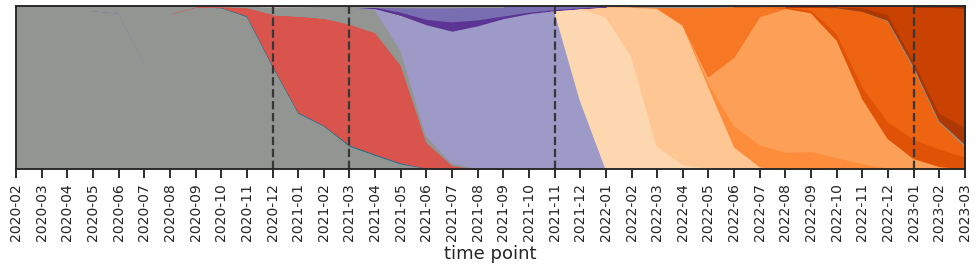

In [47]:
fig, ax = plt.subplots(figsize=(17, 3))

fish_plot(*data, ax=ax)

plt.yticks([])

names = sorted(r['name'].unique())

plt.axvline(10,
            color='xkcd:dark grey',
            ls='dashed')
plt.axvline(13,
            color='xkcd:dark grey',
            ls='dashed')
plt.axvline(21,
            color='xkcd:dark grey',
            ls='dashed')
plt.axvline(35,
            color='xkcd:dark grey',
            ls='dashed')

plt.xlabel('time point')

plt.xticks(range(len(names)),
           names,
           rotation=90,
           fontsize=14)

plt.savefig('time_9.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_9.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

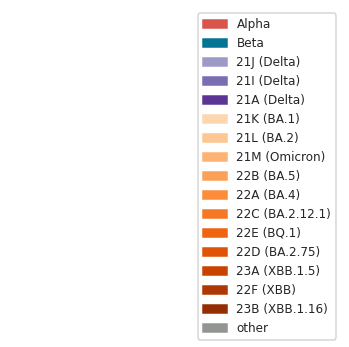

In [48]:
patches = []
for k, v in voc.items():
    if type(v) == str:
        if v != 'xkcd:grey':
            patch = mpatches.Patch(color=v, label=k)
            patches.append(patch)
    else:
        for k1, v1 in voc[k].items():
            patch = mpatches.Patch(color=v1, label=k1)
            patches.append(patch)

patch = mpatches.Patch(color='xkcd:grey', label='other')
patches.append(patch)

plt.legend(handles=patches, facecolor='w', fontsize=12, ncols=1)

plt.xticks([])
plt.yticks([])

sns.despine(left=True, bottom=True)

plt.savefig('time_9_legend.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_9_legend.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [49]:
res = []
for f in os.listdir('../out/time-lineages/'):
    l = pd.read_csv(f'../out/time-lineages/{f}', sep='\t',
                    usecols=['seqName', 'clade', 'Nextclade_pango',
                             'partiallyAliased', 'clade_nextstrain',
                             'clade_who', 'clade_display',
                             'aaSubstitutions', 'aaDeletions', 'aaInsertions'])
    date = f.split('.')[0]
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])

    d = {}
    for clade, line in l[['clade_display', 'aaSubstitutions']].values:
        for x in line.split(','):
            k, v = x.split(':')
            if k != 'S':
                continue
            while True:
                v = v[1:]
                try:
                    v = int(v)
                except ValueError:
                    v = v[:-1]
                    try:
                        v = int(v)
                    except ValueError:
                        continue
                break
            d[k] = d.get(k, set())
            d[k].add(v)

        for k, vv in d.items():
            for v in vv:
                if v in INTERESTING:
                    res.append((date, clade, k, v))

In [50]:
r = pd.DataFrame(res,
                 columns=['name', 'clade', 'gene', 'position'])

In [51]:
aa = r.groupby(['gene', 'position', 'name']).count().reset_index().pivot_table(index='position', columns='name', values='clade')
aa = aa.fillna(0)

In [52]:
aa.loc[sorted(AFFINITY)].T

position,498,501
name,,
2020-03,0.0,0.0
2020-04,0.0,1102.0
2020-05,0.0,471.0
2020-06,0.0,1060.0
2020-07,0.0,719.0
2020-08,0.0,1218.0
2020-09,0.0,1706.0
2020-10,0.0,2002.0
2020-11,0.0,2482.0


In [53]:
aa.loc[sorted(AFFINITY) + sorted(INTERESTING.difference(AFFINITY).intersection(aa.index))].T

position,498,501,417,439,440,446,447,449,452,455,456,477,484,489,493,494,496,505,681
name,,,,,,,,,,,,,,,,,,,
2020-03,0.0,0.0,0.0,2027.0,0.0,0.0,0.0,0.0,1153.0,0.0,0.0,0.0,1153.0,0.0,0.0,0.0,0.0,0.0,1153.0
2020-04,0.0,1102.0,0.0,2427.0,0.0,1923.0,0.0,0.0,107.0,0.0,0.0,2052.0,0.0,0.0,0.0,1181.0,536.0,0.0,0.0
2020-05,0.0,471.0,0.0,2266.0,0.0,1647.0,0.0,0.0,0.0,0.0,0.0,2493.0,2361.0,0.0,1169.0,105.0,0.0,0.0,2372.0
2020-06,0.0,1060.0,0.0,2311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2465.0,0.0,0.0,0.0,115.0,0.0,0.0,2480.0
2020-07,0.0,719.0,0.0,1894.0,0.0,270.0,0.0,0.0,1490.0,0.0,0.0,2478.0,681.0,0.0,0.0,0.0,0.0,0.0,2481.0
2020-08,0.0,1218.0,0.0,2493.0,1853.0,1836.0,0.0,0.0,0.0,0.0,0.0,2492.0,1090.0,0.0,0.0,2300.0,0.0,0.0,2448.0
2020-09,0.0,1706.0,0.0,2446.0,894.0,0.0,0.0,0.0,1028.0,0.0,0.0,2498.0,610.0,0.0,0.0,0.0,0.0,0.0,2467.0
2020-10,0.0,2002.0,1378.0,2458.0,0.0,0.0,0.0,0.0,2490.0,0.0,0.0,2413.0,1378.0,0.0,0.0,2475.0,0.0,0.0,1845.0
2020-11,0.0,2482.0,2392.0,2315.0,0.0,1436.0,0.0,0.0,2383.0,0.0,0.0,2435.0,2392.0,0.0,0.0,1370.0,0.0,0.0,2475.0
